In [ ]:
# # Import the 'drive' module from the 'google.colab' library
from google.colab import drive

import os              # For file and directory operations
import cv2             # For image processing and computer vision tasks
import numpy as np     # For numerical and array operations
import pandas as pd    # For data manipulation and analysis
from tensorflow import keras  # For building and training neural network models
from sklearn.model_selection import train_test_split  # For splitting data into train and test sets


# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


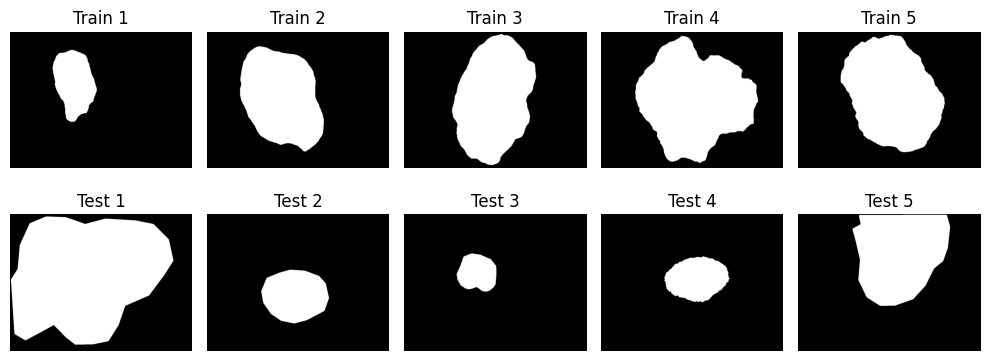

In [25]:
import cv2
from matplotlib import pyplot as plt

# Function to get first 5 image paths from a directory
def get_first_five_images(directory):
    image_paths = []
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(dirname, filename))
            if len(image_paths) == 5:
                break
        if len(image_paths) == 5:
            break
    return image_paths

# Collect first 5 images from each directory
train_images = get_first_five_images(train_dir)
test_images = get_first_five_images(test_dir)

# Set up the figure size
plt.figure(figsize=(10, 4))

# Display first 5 training images
for i, image_path in enumerate(train_images):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    plt.subplot(2, 5, i + 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Train {i+1}")
    plt.axis('off')

# Display first 5 testing images
for i, image_path in enumerate(test_images):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    plt.subplot(2, 5, i + 6)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Test {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os

# Base directory for data
base_dir = '/content'

# Paths for training and testing directories
train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Test')

# Subdirectories for training data
train_images_dir = os.path.join(train_dir, 'images')
train_masks_dir = os.path.join(train_dir, 'masks')
train_ground_truth_path = os.path.join(train_dir, 'GroundTruth.csv')

# Subdirectories for testing data
test_segmentation_dir = os.path.join(test_dir, 'ISIC2018_Task3_Test_Input')
test_classification_dir = os.path.join(test_dir, 'ISIC2016_ISIC_Part1_Test_Data')


In [ ]:
# Function for loading training images and masks
def load_images_and_masks(images_directory, masks_directory=None, load_ratio=0.5):
    # Get a list of image filenames in the images_directory
    image_filenames = [file for file in os.listdir(images_directory) if file.lower().endswith('.jpg')]

    # Select a subset of image filenames based on the load_ratio
    selected_images = image_filenames[:int(len(image_filenames) * load_ratio)]

    # Load selected images into memory using OpenCV
    loaded_images = [cv2.imread(os.path.join(images_directory, file)) for file in tqdm(selected_images, desc='Loading Images')]

    # Filter out None values (images that failed to load)
    loaded_images = [img for img in loaded_images if img is not None]

    # If masks_directory is provided, load corresponding masks
    if masks_directory:
        # Generate mask filenames by replacing '.jpg' with '_segmentation.png'
        mask_filenames = [file.replace('.jpg', '_segmentation.png') for file in selected_images]

        # Load masks as grayscale images using OpenCV
        loaded_masks = [cv2.imread(os.path.join(masks_directory, file), cv2.IMREAD_GRAYSCALE) for file in mask_filenames]

        # Filter out None values (masks that failed to load)
        loaded_masks = [mask for mask in loaded_masks if mask is not None]
    else:
        # If no masks_directory is provided, set loaded_masks to None
        loaded_masks = None

    # Return the loaded images as a NumPy array and loaded masks (if available) as a NumPy array
    return np.array(loaded_images), (np.array(loaded_masks) if loaded_masks is not None else None)


In [ ]:
# calling the load_data method
X_train, y_train_segmentation = load_data(train_images_dir, train_masks_dir)

In [ ]:
def resize_and_normalize(images, masks, target_size=(128, 128)):
    resized_images = [cv2.resize(img, target_size) / 255.0 for img in images]
    resized_and_thresholded_masks = [(cv2.resize(mask, target_size) / 255.0 > 0.5).astype(np.float32) for mask in masks]
    expanded_masks = [np.expand_dims(mask, axis=-1) for mask in resized_and_thresholded_masks]

    return np.array(resized_images), np.array(expanded_masks)

# Applying the function to preprocess training data
train_images_processed, train_masks_processed = resize_and_normalize(X_train, y_train_segmentation)


In [ ]:
# Load classification labels from the CSV file
label_dataframe = pd.read_csv(train_ground_truth_path, nrows=len(X_train_preprocessed))
class_labels = label_dataframe.iloc[:, 1:].to_numpy()

# Split the preprocessed data into training and validation sets
train_images, val_images, train_segmentation_masks, val_segmentation_masks, train_class_labels, val_class_labels = train_test_split(
    X_train_preprocessed, y_train_segmentation_preprocessed, class_labels, test_size=0.2, random_state=42)

# Organize training and validation data
train_data = {
    "images": train_images,
    "segmentation_masks": train_segmentation_masks,
    "class_labels": train_class_labels
}

val_data = {
    "images": val_images,
    "segmentation_masks": val_segmentation_masks,
    "class_labels": val_class_labels
}


In [ ]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dense, Flatten, Dropout

# Define a convolutional block with two Conv2D layers
def conv_block(input_tensor, num_filters):
    # Apply a 3x3 Conv2D layer with ReLU activation and 'same' padding
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(input_tensor)
    # Apply another 3x3 Conv2D layer with ReLU activation and 'same' padding
    x = Conv2D(num_filters, (3, 3), activation='relu', padding='same')(x)
    return x

# Define an encoder block with a convolutional block and max-pooling
def encoder_block(input_tensor, num_filters):
    # Apply a convolutional block
    x = conv_block(input_tensor, num_filters)
    # Apply max-pooling to downsample the feature map
    p = MaxPooling2D((2, 2))(x)
    return x, p

# Define a decoder block with up-sampling and concatenation
def decoder_block(input_tensor, concat_tensor, num_filters):
    # Up-sample the input tensor
    x = UpSampling2D((2, 2))(input_tensor)
    # Concatenate with the skip connection from the encoder
    x = concatenate([x, concat_tensor], axis=-1)
    # Apply a convolutional block
    x = conv_block(x, num_filters)
    return x

# Define a U-Net model for both segmentation and classification
def build_unet_classification(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    x1, p1 = encoder_block(inputs, 32)
    x2, p2 = encoder_block(p1, 64)
    x3, p3 = encoder_block(p2, 128)
    x4, p4 = encoder_block(p3, 256)

    # Bottleneck
    b = conv_block(p4, 512)

    # Decoder
    d1 = decoder_block(b, x4, 256)
    d2 = decoder_block(d1, x3, 128)
    d3 = decoder_block(d2, x2, 64)
    d4 = decoder_block(d3, x1, 32)

    # Output layers for segmentation and classification
    segmentation_output = Conv2D(1, (1, 1), activation='sigmoid', name='segmentation_output')(d4)

    # Flatten and use a dropout for the classification path
    flatten_layer = Flatten()(d4)
    dense_layer = Dense(128, activation='relu')(flatten_layer)
    dropout_layer = Dropout(0.5)(dense_layer)
    classification_output = Dense(num_classes, activation='softmax', name='classification_output')(dropout_layer)

    # Create the U-Net model with both segmentation and classification outputs
    model = Model(inputs=inputs, outputs=[segmentation_output, classification_output])

    return model


In [ ]:
# getting the summary of the model
model = build_unet_classification(X_train.shape[1:], num_classes=df.shape[1] - 1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [ ]:
from keras.optimizers import Adam
from keras.losses import binary_crossentropy, categorical_crossentropy

# Compile the model with custom loss and separate metrics for each output
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss={'segmentation_output': 'binary_crossentropy',
                    'classification_output': 'categorical_crossentropy'},
              metrics={'segmentation_output': 'accuracy',
                       'classification_output': 'accuracy'})





In [ ]:
import keras.backend as K

def custom_jaccard_index(y_true, y_pred, smooth=1e-5):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    sum_areas = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[1,2,3])
    jaccard = (intersection + smooth) / (sum_areas - intersection + smooth)
    return K.mean(jaccard)

def weighted_categorical_accuracy(y_true, y_pred):
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_true_labels = K.argmax(y_true, axis=-1)

    class_totals = K.sum(y_true, axis=0)
    class_weights = 1.0 / (class_totals + K.epsilon())

    matched = K.cast(K.equal(y_true_labels, y_pred_labels), K.floatx())
    weighted_matches = matched * class_weights
    weighted_accuracy = K.sum(weighted_matches) / K.sum(class_weights)
    return weighted_accuracy


In [ ]:
from keras.optimizers import Adam

# Setting up the model for training
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Adam optimizer with a specified learning rate

    # Loss functions for each task
    loss={
        'segmentation_output': 'binary_crossentropy',  # Loss for the segmentation task
        'classification_output': 'categorical_crossentropy'  # Loss for the classification task
    },

    # Metrics to monitor for each task
    metrics={
        'segmentation_output': custom_jaccard_index,  # Custom Jaccard Index for segmentation evaluation
        'classification_output': weighted_categorical_accuracy  # Weighted accuracy for classification evaluation
    }
)


In [ ]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=7,
    batch_size=32,
)

Epoch 1/7
126/126 [==============================] - ETA: 0s - loss: 1.8198 - segmentation_output_loss: 0.6925 - classification_output_loss: 1.1273 - segmentation_output_jaccard_index: 0.9950 - classification_output_normalized_multiclass_accuracy: 0.0101
Epoch 1: val_loss improved from inf to 1.61058, saving model to best_model.tf
126/126 [==============================] - 30s 121ms/step - loss: 1.8198 - segmentation_output_loss: 0.6925 - classification_output_loss: 1.1273 - segmentation_output_jaccard_index: 0.9950 - classification_output_normalized_multiclass_accuracy: 0.0101 - val_loss: 1.6106 - val_segmentation_output_loss: 0.6903 - val_classification_output_loss: 0.9203 - val_segmentation_output_jaccard_index: 0.9950 - val_classification_output_normalized_multiclass_accuracy: 0.0220
Epoch 2/7
125/126 [============================>.] - ETA: 0s - loss: 1.6479 - segmentation_output_loss: 0.6878 - classification_output_loss: 0.9601 - segmentation_output_jaccard_index: 0.9951 - classif

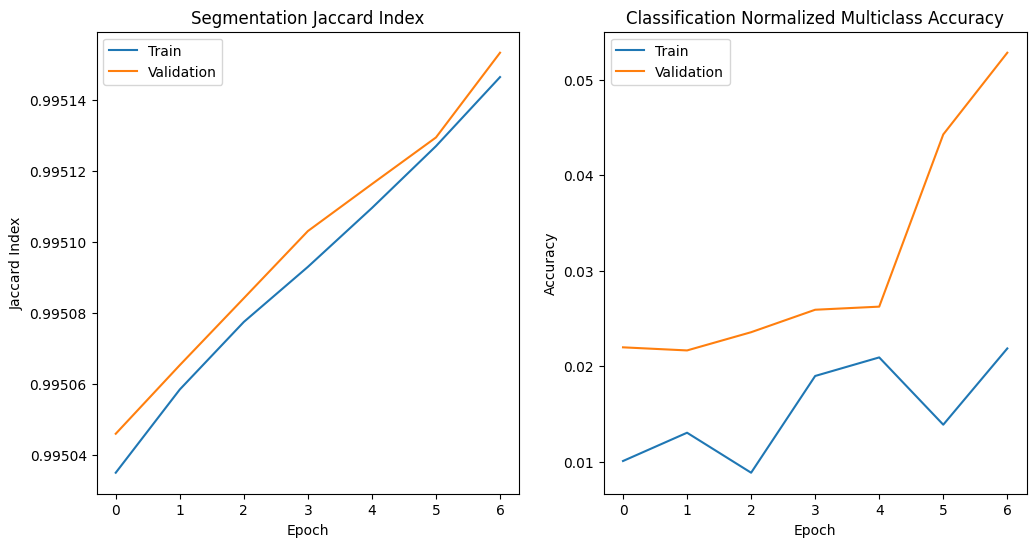

In [ ]:
# Set up the plot for training and validation metrics
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Segmentation Jaccard Index plot
axes[0].plot(history.history['segmentation_output_jaccard_index'], label='Train Jaccard Index')
axes[0].plot(history.history['val_segmentation_output_jaccard_index'], label='Validation Jaccard Index')
axes[0].set_title('Segmentation Jaccard Index Over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Jaccard Index')
axes[0].legend()

# Classification Normalized Multiclass Accuracy plot
axes[1].plot(history.history['classification_output_normalized_multiclass_accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_classification_output_normalized_multiclass_accuracy'], label='Validation Accuracy')
axes[1].set_title('Classification Accuracy Over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Normalized Accuracy')
axes[1].legend()

# Display the plots
plt.tight_layout()
plt.show()
